# Estimating default risk using  LendingClub data

### Overview

LendingClub is a peer-to-peer lending company that has originated over $50 billion in loans. LendingClub provides a platform where borrowers can obtain loans and investors can invest in notes backed by payments on the loans. Interest rates are based on the likelihood that the borrower will be able to make interest payments and return the principal. Estimating an optimal interest rate and predicting the probability of default is important to both the company and investors who seek to minimize risk and maximize returns.

In this exercise, you will use LendingClub data to predict the probability of default. You will use machine learning techniques to determine the likelihood of default within a specific grade of loan. LendingClub originates loans with different grades that are based on risk and a corresponding interest rate. Higher interest rates correspond to riskier grades. 

The data consists of every loan issued from 2007 to 2018. You will use the data to train and test a logistic regression model to determine probability of default. The data consists of 151 fields, including income, location, and occupation. The exercise will require you to derive a training set and test set of the data. The goal is to use a machine learning model to classify the loans as either good or bad.

### Contents

1. Introduction
    * Goal
    * Data
    * Model
2. Import Python libraries
    * pandas
    * numpy
    * scipy
3. Import data
    * CSV file (2GB)
4. Target variable
5. Feature selection
    * Select features available to investors
    * Remove features lacking data
6. Preprocessing
    * Convert variables to integers
    * Create dummy variables
7. Logistic regression
    * Training
    * Testing
    * Fitting the model
    * Scoring the model

### (1) Introduction

The goal is to classify which loans are expected to default. 

The data is retrived from LendingClub's website. https://www.lendingclub.com/info/download-data.action

A logistic regression model is used to perform the classification exercise.

Your assignment will be to complete any tasks and questions listed throughout the notebook. You will also need to input the code in the logistic regression section as demonstrated in class.

### (2) Import Python libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl
import time

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

**TASK: Look up and provide a brief description of the seaborn library as a comment to the right of the import statement.**

### (3) Import data

Data is imported as a CSV file. It is over 2GB is size, so please allow time for it to load. 

In [2]:
start = time.time() # start timer to measure processing time
lc_df = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False) # load the CSV file
end = time.time() # end timer
print("Time elapsed:", (end - start),"seconds") # display time elapsed

Time elapsed: 241.08604216575623 seconds


**Task: Change the above code to round seconds to the nearest whole number. Refer to the documentation: https://docs.python.org/3/library/functions.html**

In [3]:
# Check dataframe info
lc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [4]:
# What does the data look like
lc_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check datatype of each column
lc_df.dtypes

id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                      float64
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

In [6]:
# Unique values for our target variable
lc_df['loan_status'].nunique()

9

In [7]:
lc_df['loan_status']

0           Fully Paid
1           Fully Paid
2           Fully Paid
3              Current
4           Fully Paid
5           Fully Paid
6           Fully Paid
7           Fully Paid
8           Fully Paid
9           Fully Paid
10             Current
11             Current
12          Fully Paid
13         Charged Off
14          Fully Paid
15          Fully Paid
16          Fully Paid
17          Fully Paid
18             Current
19          Fully Paid
20          Fully Paid
21          Fully Paid
22          Fully Paid
23          Fully Paid
24          Fully Paid
25         Charged Off
26          Fully Paid
27          Fully Paid
28          Fully Paid
29          Fully Paid
              ...     
2260671        Current
2260672    Charged Off
2260673    Charged Off
2260674     Fully Paid
2260675     Fully Paid
2260676        Current
2260677    Charged Off
2260678        Current
2260679        Current
2260680     Fully Paid
2260681        Current
2260682        Current
2260683    

###  (4) Target variable

Computing the value counts for the loan_status variable, which is the variable we are going to predict.

In [8]:
lc_df['loan_status'].value_counts(dropna=False)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: loan_status, dtype: int64

For the loan_status target variable, we want only the rows with loans that were fully paid ('Fully Paid') or defaulted ('Charged Off'). We will remove the remaining rows in the dataset.

In [9]:
# Create a series of boolean values representing of the observations to keep
bool_keep = lc_df['loan_status'].isin(['Fully Paid', 'Charged Off'])

In [10]:
bool_keep.sample(15)

1767167     True
356089      True
1764473     True
741134      True
221077      True
1456100    False
1882679     True
1388655    False
1834270     True
530573      True
72306       True
2115686     True
578835     False
840583     False
1117507     True
Name: loan_status, dtype: bool

In [11]:
# Map the series of boolean values to the dataset and select only True rows
lc_df = lc_df.loc[bool_keep]

In [12]:
# Check value counts again
lc_df['loan_status'].value_counts()

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

In [13]:
# Check the number of rows (observations) and columns (features)
lc_df.shape

(1345310, 151)

In [14]:
# Value counts as percentages
lc_df['loan_status'].value_counts(normalize=True)

Fully Paid     0.800374
Charged Off    0.199626
Name: loan_status, dtype: float64

In [15]:
lc_df.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
5,68426831,NaN,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
6,68476668,NaN,20000.0,20000.0,20000.0,36 months,9.17,637.58,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
7,67275481,NaN,20000.0,20000.0,20000.0,36 months,8.49,631.26,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
8,68466926,NaN,10000.0,10000.0,10000.0,36 months,6.49,306.45,A,A2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
9,68616873,NaN,8000.0,8000.0,8000.0,36 months,11.48,263.74,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
12,68338832,NaN,1400.0,1400.0,1400.0,36 months,12.88,47.10,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


### (5) Feature selection

Currently the dataset has 151 features. We will remove features with substantial missing values and features that would not be available to investors.

We will drop features missing more than 20% of its data. Of the remaining features, we will then select the ones that would be available to investors prior to financing the loan.

In [16]:
null_values = lc_df.isnull()

In [17]:
percent_null = null_values.mean()

In [18]:
percent_null = percent_null.sort_values(ascending=False)

In [19]:
# features missing the most data
percent_null.head(10)

member_id                                     1.000000
next_pymnt_d                                  1.000000
orig_projected_additional_accrued_interest    0.997206
hardship_start_date                           0.995723
hardship_end_date                             0.995723
payment_plan_start_date                       0.995723
hardship_length                               0.995723
hardship_dpd                                  0.995723
hardship_loan_status                          0.995723
hardship_last_payment_amount                  0.995723
dtype: float64

Text(0, 0.5, 'features')

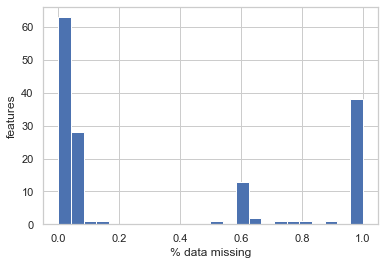

In [20]:
# Visualize the distribution of missing data percentages
plt.figure()
percent_null.plot.hist(bins=24)
plt.xlabel('% data missing')
plt.ylabel('features')

Select and store in alphabetical order the variables with more than 20% of values missing.

In [21]:
percent_null = percent_null[percent_null > 0.2]

In [22]:
features_drop = sorted(percent_null[percent_null > 0.2].index)

Number of features with more than 20% values missing:

In [23]:
len(features_drop)

58

Remove these features using the pandas 'drop' method:

In [24]:
lc_df.shape

(1345310, 151)

In [25]:
lc_df.drop(labels=features_drop, axis=1, inplace=True)

In [26]:
lc_df.shape

(1345310, 93)

93 features remain after removing variables with more the 20% missing values.

Now we need to identify features that would be available for financing decisions.

In [27]:
features_keep = [
    'addr_state', 'annual_inc', 'application_type', 'fico_range_high', 
    'fico_range_low', 'home_ownership', 'initial_list_status', 
    'installment', 'int_rate', 'loan_amnt', 'loan_status', 
    'open_acc', 'pub_rec', 'purpose', 'revol_bal', 
    'sub_grade', 'term', 'total_acc', 'verification_status'
    ]

In [28]:
print(features_keep)

['addr_state', 'annual_inc', 'application_type', 'fico_range_high', 'fico_range_low', 'home_ownership', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'open_acc', 'pub_rec', 'purpose', 'revol_bal', 'sub_grade', 'term', 'total_acc', 'verification_status']


In [29]:
len(features_keep)

19

Now we make a list of the features we do not want to use in the model. 

In [30]:
features_drop = [x for x in lc_df.columns if x not in features_keep]
print(features_drop)
print("Number of features to drop:", (len(features_drop)))

['id', 'funded_amnt', 'funded_amnt_inv', 'grade', 'emp_title', 'emp_length', 'issue_d', 'pymnt_plan', 'url', 'title', 'zip_code', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'revol_util', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_g

In [31]:
lc_df.drop(labels=features_drop, axis=1, inplace=True)

In [32]:
lc_df.shape 

(1345310, 19)

**QUESTION: How many features are left in the dataset? How many observations?**

Answer:  There are 19 features in this dataset and 1345310 observations in the dataset 

### 6 - Preprocessing

Convert strings to integers for 'term' feature and 'emp_length' feature:

In [33]:
# Convert term to integers
lc_df['term'] = lc_df['term'].apply(lambda s: np.int8(s.split()[0]))

Use dummy variables for loan_status target feature:

In [34]:
lc_df['charged_off'] = (lc_df['loan_status'] == 'Charged Off').apply(np.uint8)
lc_df.drop('loan_status', axis=1, inplace=True)

In [35]:
lc_df["charged_off"]

(1345310, 19)

Create dummy variables fo the categorical features:

In [36]:
lc_df.dtypes

loan_amnt              float64
term                     int64
int_rate               float64
installment            float64
sub_grade               object
home_ownership          object
annual_inc             float64
verification_status     object
purpose                 object
addr_state              object
fico_range_low         float64
fico_range_high        float64
open_acc               float64
pub_rec                float64
revol_bal              float64
total_acc              float64
initial_list_status     object
application_type        object
charged_off              int64
dtype: object

In [37]:
lc_df = pd.get_dummies(lc_df, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

In [38]:
lc_df.shape

(1345310, 118)

In [39]:
lc_df.sample(10)

,loan_amnt,term,int_rate,installment,annual_inc,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,...,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
1632538,7000.0,36,12.68,234.79,35000.00,670.0,674.0,12.0,0.0,9185.0,...,0,0,0,0,0,0,0,0,0,0
37931,30000.0,36,7.89,938.57,72000.00,680.0,684.0,6.0,0.0,18468.0,...,0,0,0,0,0,0,0,0,1,0
200296,14050.0,36,15.61,491.26,45086.92,675.0,679.0,7.0,0.0,2748.0,...,0,0,0,0,0,0,0,0,1,0
1107106,7000.0,36,9.17,223.16,45000.00,660.0,664.0,9.0,1.0,3501.0,...,0,0,0,0,0,0,0,0,1,0
1136330,11500.0,36,11.44,378.90,70000.00,660.0,664.0,8.0,0.0,26518.0,...,0,0,0,0,0,0,0,0,1,0
1259606,15000.0,36,12.49,501.74,74000.00,675.0,679.0,9.0,0.0,31041.0,...,0,0,1,0,0,0,0,0,1,0
32250,12000.0,36,7.89,375.43,62000.00,680.0,684.0,13.0,0.0,11522.0,...,0,0,0,0,0,0,0,0,1,0
1489743,20000.0,36,17.47,717.75,28920.00,695.0,699.0,10.0,0.0,7025.0,...,0,0,0,0,0,0,0,0,1,0
1333593,1600.0,36,11.99,53.14,90000.00,685.0,689.0,8.0,0.0,3547.0,...,0,0,0,0,0,0,0,0,0,0
1147142,6400.0,36,12.39,213.77,75000.00,670.0,674.0,14.0,0.0,26328.0,...,0,0,0,0,0,1,0,0,1,0


### 7 - Logistic regression

Create training/test sets:

In [44]:
from sklearn.model_selection import train_test_split

In [48]:
train, test = train_test_split(lc_df,test_size=0.2)

In [49]:
train.shape

(1076248, 118)

In [50]:
test.shape

(269062, 118)

In [51]:
test_data = test.drop(["charged_off"], axis = 1)

In [52]:
test_data.shape

(269062, 117)

In [53]:
y_test_data = test["charged_off"]

In [54]:
y_test_data.shape

(269062,)

In [55]:
y_training_data = train["charged_off"]

In [56]:
x_train_data = train.drop(["charged_off"], axis=1)

In [57]:
x_train_data.head

<bound method NDFrame.head of          loan_amnt  term  int_rate  installment  annual_inc  fico_range_low  \
1266079     4500.0    36     15.61       157.35    64000.00           670.0   
1337594     1000.0    36     19.97        37.15   100000.00           660.0   
2172927    20000.0    36     14.99       693.21   105000.00           660.0   
1853067    21350.0    36     12.12       710.35    52000.00           700.0   
1087019    16000.0    36     11.48       527.47    80000.00           670.0   
1729618    18000.0    36     10.49       584.96    70000.00           715.0   
1891229    10000.0    36     14.09       342.22    55000.00           700.0   
1782141     8000.0    36      6.03       243.49   120000.00           745.0   
1233947    12000.0    36     22.15       459.22    65000.00           660.0   
56342       5000.0    36      6.89       154.14    45000.00           730.0   
1828638     9975.0    36     15.88       350.11    59000.00           695.0   
1326927    35000.0    

In [59]:
y_training_data.head

<bound method NDFrame.head of 1266079    0
1337594    0
2172927    1
1853067    0
1087019    0
1729618    0
1891229    0
1782141    0
1233947    0
56342      1
1828638    0
1326927    0
187829     0
77748      0
1007709    1
1136002    0
1884970    0
1936551    0
1294955    0
23965      0
1164496    0
1101089    0
1087987    0
1300989    0
733407     0
1871994    0
1902054    0
1164102    0
511335     0
1169249    0
          ..
1790873    0
320911     1
1235987    1
1147281    0
82086      0
1169060    0
301847     0
115613     0
569181     0
119344     1
367983     0
2187865    0
690506     0
602114     0
677925     0
1899459    0
2048974    1
1934690    0
727674     0
361        1
209651     0
1849337    1
1768626    0
984636     0
1152719    1
326297     0
1142013    0
41096      0
1637458    0
1202099    0
Name: charged_off, Length: 1076248, dtype: int64>

In [61]:
# 1. Import the model
from sklearn.linear_model import LogisticRegression

In [62]:
# 2. Make an instance of the model
logreg_model = LogisticRegression(class_weight='balanced')

In [64]:
# 3. Training the model
logreg_model.fit(x_train_data, y_training_data)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
# 4. Predict from test data
predictions = logreg_model.predict(test_data)

In [67]:
predictions

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:
predict.

We will measure performance using the accuracy of the model.

accuracy = correct predictions / total number of data points

Other methods include AUC, precision, recall, etc.

In [68]:
# Use the score method to return the accuracy of the model
score = logreg_model.score(test_data, y_test_data)

In [70]:
print (score)

0.6597252677821469


The result is the percentage of observations that your model correctly predicted. 